# Customer segmentation - k-prototypes

tipos de segmentação de consumidores

- comportamental: padrões de consumo, quantidade e qualidade
- psicográfica: estilo de vida, opiniões, crenças
- geográfica: estado, cidade, bairro
- demográfica: gênero, estado civil, idade, profissão, etc
- value-based: a receita que eles geram

passos do projeto

- entender e preparar os dados
- encontrar o número de clusters usando o algoritmo k-prototypes
- plotar os clusters

créditos: https://www.youtube.com/watch?v=Iit7y3H_yqY&ab_channel=AIDecoder

### 0. Bibliotecas

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from kmodes.kprototypes import KPrototypes
from kneed import KneeLocator

### 1. Base de dados

In [4]:
data = pd.read_csv('Data.csv')

# deletar colunas desnecessárias
data.drop(['ID', 'Unnamed: 0'], axis = 'columns', inplace = True)

In [5]:
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6


In [7]:
data.shape

(8068, 9)

In [10]:
data.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64

In [11]:
data.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


In [12]:
data.columns

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1'],
      dtype='object')

In [14]:
# quais são as categorias nas variáveis categóricas?

df_cat = data[['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']]

for i in df_cat.columns:
    print(i, df_cat[i].unique())

Gender ['Male' 'Female']
Ever_Married ['No' 'Yes' nan]
Graduated ['No' 'Yes' nan]
Profession ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan]
Spending_Score ['Low' 'Average' 'High']
Var_1 ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5']


### 2. Transformações nos dados

In [17]:
# transform categorical labels to numerical labels

df_cat = data[['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']]

encoders = {}

for col_name in df_cat.columns:
    series = df_cat[col_name]
    label_encoder = LabelEncoder()
    df_cat[col_name] = pd.Series(label_encoder.fit_transform(series[series.notnull()]),
                                 index = series[series.notnull()].index
                                 )
    encoders[col_name] = label_encoder

C:\Users\Leticia\AppData\Local\Temp\ipykernel_920\2786427338.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[col_name] = pd.Series(label_encoder.fit_transform(series[series.notnull()]),
C:\Users\Leticia\AppData\Local\Temp\ipykernel_920\2786427338.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[col_name] = pd.Series(label_encoder.fit_transform(series[series.notnull()]),
C:\Users\Leticia\AppData\Local\Temp\ipykernel_920\2786427338.py:10: SettingWithCopyWarning: 
A value is trying to be

In [18]:
encoders

{'Gender': LabelEncoder(),
 'Ever_Married': LabelEncoder(),
 'Graduated': LabelEncoder(),
 'Profession': LabelEncoder(),
 'Spending_Score': LabelEncoder(),
 'Var_1': LabelEncoder()}

In [23]:
# completar missings usando KNN para variáveis numéricas e categóricas

# numerical values
df_num = data[['Age', 'Work_Experience', 'Family_Size']]
imputer = KNNImputer(n_neighbors = 5)
df_num.loc[:] = imputer.fit_transform(df_num)

# categorical values
imputer = KNNImputer(n_neighbors = 1)
df_cat.loc[:] = imputer.fit_transform(df_cat)

# concatenar os dados
data = pd.concat([df_cat, df_num], axis = 1)

In [24]:
# transformar os dados com PCA para posteriormente visualizar os clusters

pca = PCA(2)

# transformar os dados
d_f = pca.fit_transform(data)

d_f.shape

(8068, 2)

In [25]:
# decode categorical data (k-prototypes trabalha com dados categóricos brutos)

for i in df_cat.columns:
    data[i] = data[i].astype(int)

for col_name in df_cat.columns:
    data[col_name] = encoders[col_name].inverse_transform(data[col_name])

In [26]:
# conferir se os nulos foram preenchidos

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     8068 non-null   object 
 2   Graduated        8068 non-null   object 
 3   Profession       8068 non-null   object 
 4   Spending_Score   8068 non-null   object 
 5   Var_1            8068 non-null   object 
 6   Age              8068 non-null   int64  
 7   Work_Experience  8068 non-null   float64
 8   Family_Size      8068 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 567.4+ KB


In [27]:
# pegar a posição das variáveis categóricas

cat_columns_position = [data.columns.get_loc(col) for col in list(data.select_dtypes('object').columns)]

print('Categorical columns: {}'.format(list(data.select_dtypes('object').columns)))
print('Categorical columns position: {}'.format(cat_columns_position))

Categorical columns: ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
Categorical columns position: [0, 1, 2, 3, 4, 5]


In [28]:
# converter dataframe em matriz

df_matrix = data.to_numpy()

### 3. Clusterização

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


<function matplotlib.pyplot.show(close=None, block=None)>

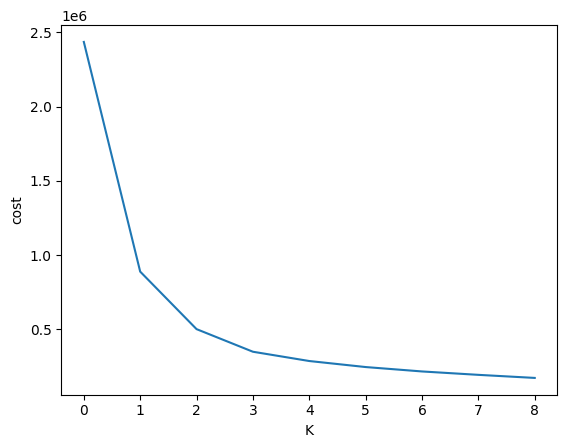

In [29]:
# método elbow para detectar número de K

cost = []

for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(df_matrix, categorical = cat_columns_position)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [32]:
# cost (sum distance): confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concave, will detect knees

cost_knee_c3 = KneeLocator(
    x = range(1, 10),
    y = cost,
    S = 0.1,
    curve = 'convex',
    direction = 'decreasing',
    online = True
)

K_cost_c3 = cost_knee_c3.elbow
print('elbow at k = ', f'{K_cost_c3:.0f} clusters')

elbow at k =  3 clusters


In [33]:
# build the k-prototype model with 3 clusters

kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
data['clusters'] = kprototype.fit_predict(df_matrix, categorical = cat_columns_position)

### 4. Visualizar os clusters

In [34]:
# predict the labels of clusters

label = kprototype.fit_predict(df_matrix, categorical = cat_columns_position)
print(label)

[1 2 0 ... 1 1 2]


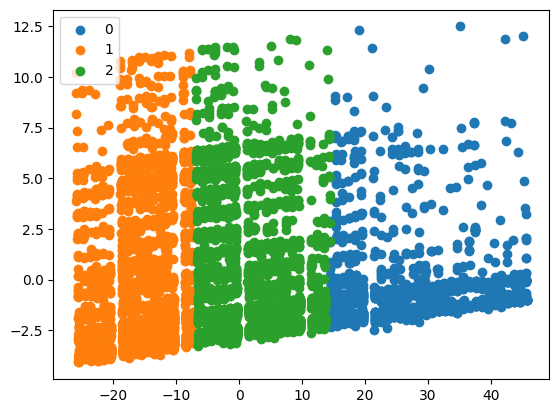

In [35]:
# getting unique labels

u_labels = np.unique(label)

# plotting the results

for i in u_labels:
    plt.scatter(d_f[label == i, 0],
                d_f[label == i, 1],
                label = i)

plt.legend()
plt.show()

### 5. Análise

<Axes: xlabel='clusters'>

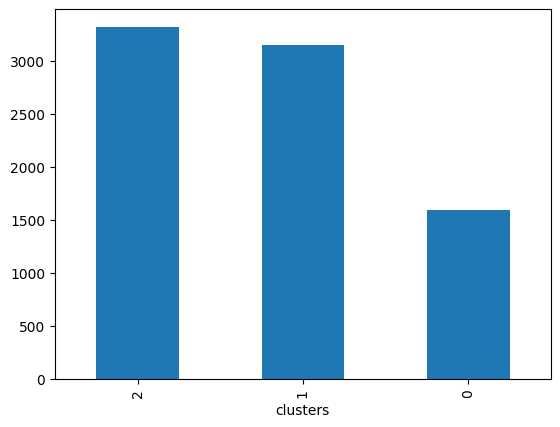

In [36]:
# volume de cada cluster

data['clusters'].value_counts().plot(kind = 'bar')

In [38]:
data

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Age,Work_Experience,Family_Size,clusters
0,Male,No,No,Healthcare,Low,Cat_4,22,1.0,4.0,1
1,Female,Yes,Yes,Engineer,Average,Cat_4,38,4.4,3.0,2
2,Female,Yes,Yes,Engineer,Low,Cat_6,67,1.0,1.0,0
3,Male,Yes,Yes,Lawyer,High,Cat_6,67,0.0,2.0,0
4,Female,Yes,Yes,Entertainment,High,Cat_6,40,7.4,6.0,2
...,...,...,...,...,...,...,...,...,...,...
8063,Male,No,No,Healthcare,Low,Cat_1,22,0.0,7.0,1
8064,Male,No,No,Executive,Low,Cat_4,35,3.0,4.0,1
8065,Female,No,Yes,Healthcare,Low,Cat_6,33,1.0,1.0,1
8066,Female,No,Yes,Healthcare,Low,Cat_6,27,1.0,4.0,1


In [41]:
# média dos dados numéricos de cada cluster

data[['Age', 'Work_Experience', 'Family_Size', 'clusters']].groupby(['clusters']).mean()

,Age,Work_Experience,Family_Size
clusters,,,
0,70.184442,1.365872,2.262861
1,27.856916,3.180330,3.322081
2,45.458158,2.732992,2.695485


In [39]:
# moda dos dados categóricos pela moda

data.groupby(['clusters']).agg(lambda x: pd.Series.mode(x).iat[0])[['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']]

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
clusters,,,,,,
0,Male,Yes,Yes,Lawyer,Low,Cat_6
1,Male,No,No,Healthcare,Low,Cat_6
2,Male,Yes,Yes,Artist,Low,Cat_6


In [21]:
data['Gender'].value_counts()

Gender
Male      4417
Female    3651
Name: count, dtype: int64